In [227]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import mesa
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import pickle
from ipywidgets import interact, IntSlider, SelectionSlider, Layout, fixed
import numpy as np
from tqdm import tqdm
slider_layout = Layout(width='300px')

**QUESTIONS:**

- Many of the model parameter values are pretty randomly chosen -- do we have better ways of selecting them? There are currently so many parameters that running the model for each combination of a decent number of options for each of the parameters would take very very very long, so ideally we fix at least a few of the parameters. Here are all of them (see below for more explanation):
    - error: proportion of false positives and false negatives in peer review without ideological bias
    - p_false_positive: increase in proportion in false positives due to ideological bias
    - p_false_negative: increase in proportion in false negatives due to ideological bias
    - p_neutral_start: proportion of neutral researchers in the starting population
    - p_liberal_start: proportion of liberal researchers in the starting population
    - p_true_start: proportion of true ideas in the starting population of ideas
    - p_neutral_ideas_start: proportion of neutral ideas at the start
    - p_liberal_ideas_start: proportion of liberal ideas at the start
    - p_new_idea: probability in any given step of each researcher to launch a new idea 
    - p_new_idea_true: probability that a newly launched idea is true
    - p_ideology_idea: probability that a newly launched idea has the same ideology as the launcher
    - prop_remove_ideas: the proportion of ideas that gets forgotten each step
    - prop_minim_neutral: minimal proportion of neutral researchers in new hires
    - cost_neutral: a value that indicates how much liberal/conservative should grow compared to neutral
    
- The model is very complex, with a lot of parameters. Are there superfluous dynamics/parameters that we can eliminate?
- The procedure of hiring new researchers has a lot of influence on the distribution of orientations in the population. At the moment we have a very arbitrary rule that hires new researchers weighted by the existing proportions of ideologies of both ideas and researchers, combined with a punishment against neutral researchers (such that academia will become more ideological by design). We need to think about this, because long-term this is what determines a lot of the outcomes.

**The model has the following assumptions about researchers:**

*Idealogical Orientation:*
- Each researcher has an ideological orientation (neutral, liberal, conservative).
- The starting population consists of p_neutral_start neutral researchers, p_liberal_start Liberal researchers, and the rest conservative. This is supposed to reflect the 1950s.
- When a researcher retires, they get replaced by another researcher. The orientation of new researchers is determined by:
    - the combined proportions (equal weight) of orientations of ideas and researchers in the population.
    - a factor cost_neutral sets how much heavier the proportions of liberal and conservative researchers should weigh in determining the orientation of a new researcher. If this is larger than 1, the proportion of neutral researchers will always decline.
    - a prop_minim_neutral, which indicates what minimum proportion of new hires should be neutral.


*Ageing*:
- Researchers in the initial population have a random age between 25 and 65, and each step, a researcher ages 6 months.
- Researchers retire when they are 65, and then they are replaced by someone who's 25.


*Launching and reviewing ideas:*

- Every six months, each researcher launches a new idea with a probability of p_new_idea (currently 0.8)
- This idea has a probability of being true of p_new_idea_true (currently 0.5)
- This idea has a probability of having the same ideological orientation as the researcher of p_ideology_idea (currently 0.9). If not the same, then the idea is neutral.
- This idea is reviewed by two random other researchers from the population, and only added to the population of ideas if both reviewers think the idea is true.

**The model has the following assumptions about ideas:**

- All ideas have an idealogical orientation (neutral, liberal, conservative).
- The proportions of ideologies in the initial population are managed by 'p_neutral_ideas_start' and 'p_liberal_ideas_start'. The proportions after that are influenced by the probability of new ideas being ideological (see above) and by the peer review process that filters ideas.
- All ideas are either true or false. The proportion of true ideas in the initial population is p_true_start.
- Each step, prop_remove_ideas of all ideas is forgotten. These ideas to be removed are selected randomly.

**The model has the following assumptions about peer review:**

- Each newly launched idea is reviewed by two random resaerchers, and only admitted to the population if it gets considered True by each reviewer.
- Reviewers have basic false positive and false negative raters set by error.
- If a reviewer reviews a paper with their own ideological orientation (liberal reviewing liberal or conservative reviewing conservative -- no effect for neutral ideas or resaerchers), their false positive and false negative rates change:
    - If the ideology of idea and reviewer is the same, the false positive rate (false papers being considered true) increases by p_false_positive.
    - If the ideology of idea and reviewer is different, the false negative rate (true papers being considered false) increases by p_false_negative
    
**Potential other features to add:**
- Add an editorial stage to the peer review process, where an editor can decide to publish mixed reviews (one false one true) if they are more in line with their ideology.
- Make orientation a continuous property on a scale between -1 and 1, where 0 is neutral, -1 is extremely liberal, and 1 is extremely conservative. Alternatively, we could increase the number of ideological categories (extreem left, left, neutral, right, extreem right).
- Add hiring dynamics: 
    - replace researchers that retire by researchers with a certain probability of having the same orientation.
    - discriminate against the minority orientation
    - ...
- Add self-censure dynamics: Make minority researchers less likely to publish ideas that align with their orientation.
- Add spatial features: Add a network or 2D space to the model in which researchers that are connected or more closely together are more likely to interact/more likely to be of the same orientation/...

# Set up of the model

**Run all the cells in this chapter without trying to understand them.**

In [543]:
# define the researchers


class Researcher(Agent):
    # An agent with fixed ideological orientation and variable seniority.
    def __init__(self, unique_id, model, orientation, seniority, p_new_idea,p_new_idea_true,p_ideology_idea):
        super().__init__(unique_id, model)
        self.orientation = orientation
        self.seniority = seniority

    # manage aging and launching ideas
    def step(self):
        self.seniority += 0.5
        if self.seniority >= 65:
            self.retire()
        if random.random() < p_new_idea:
            self.launch_idea()
    
    def retire(self):
            # For simplicity, mark as retired. Actual implementation might involve removing or replacing the agent
            self.orientation = "retired"

    def launch_idea(self):
        
        # how many of their ideas should be ideological?
        orientation = self.orientation if random.random() < p_ideology_idea else "neutral"
        truth_value = random.choices([True, False], weights=[p_new_idea_true,1-p_new_idea_true], k=1)[0]
        new_idea = Idea(self.model.next_id(), self.model, orientation, truth_value, self.unique_id)
        self.model.review_queue.append(new_idea)



In [544]:
# define the ideas

class Idea(Agent):
    def __init__(self, unique_id, model, orientation, truth_value, originator_id):
        super().__init__(unique_id, model)
        self.orientation = orientation
        self.truth_value = truth_value
        self.originator_id = originator_id

In [545]:
# the model

class ResearchModel(Model):
    """
    Parameters:
    - N: Number of researchers in the population (constant).
    - num_ideas: number of ideas in the starting pool.
    - error: proportion of false positives and false negatives in peer review without ideological bias
    - p_false_positive: increase in proportion in false positives due to ideological bias
    - p_false_negative: increase in proportion in false negatives due to ideological bias
    - p_neutral_start: proportion of neutral researchers in the starting population
    - p_liberal_start: proportion of liberal researchers in the starting population
    - p_true_start: proportion of true ideas in the starting population of ideas
    - p_neutral_ideas_start: proportion of neutral ideas at the start
    - p_liberal_ideas_start: proportion of liberal ideas at the start
    - p_new_idea: probability in any given step of each researcher to launch a new idea 
    - p_new_idea_true: probability that a newly launched idea is true
    - p_ideology_idea: probability that a newly launched idea has the same ideology as the launcher
    - prop_remove_ideas: the proportion of ideas that gets forgotten each step
    - prop_minim_neutral: minimal proportion of neutral researchers in new hires
    - cost_neutral: a value that indicates how much liberal/conservative should grow compared to neutral
    """

        
    def __init__(self, N, num_ideas, error, p_false_positive, p_false_negative, p_neutral_start, p_liberal_start, 
                p_true_start, p_neutral_ideas_start, p_liberal_ideas_start,
                 p_new_idea,p_new_idea_true,p_ideology_idea, prop_remove_ideas, prop_minim_neutral, cost_neutral):
        
        super().__init__()
        self.running = True
        self.num_agents = N
        self.current_id = 0
        self.schedule = RandomActivation(self)
        
        self.initialize_researchers(N,p_new_idea,p_new_idea_true,p_ideology_idea)

        
        self.review_queue = []  # Queue of ideas waiting for review
        # Initialize researchers and ideas as before

        # Create researchers
        
        self.initialize_ideas(num_ideas)
        
        # Data collector
        self.datacollector = DataCollector(
            {"Liberal Researchers": lambda m: self.count_orientation(m, "liberal", Researcher),
             "Conservative Researchers": lambda m: self.count_orientation(m, "conservative", Researcher),
             "Neutral Researchers": lambda m: self.count_orientation(m, "neutral", Researcher),
             "Liberal Ideas": lambda m: self.count_orientation(m, "liberal", Idea),
             "Conservative Ideas": lambda m: self.count_orientation(m, "conservative", Idea),
             "True Ideas": lambda m: self.count_truth(m, 1),
             "False Ideas": lambda m: self.count_truth(m, 0),
        "Neutral Ideas": lambda m: self.count_orientation(m, "neutral", Idea),
            "Proportion Accepted": lambda m: ((m.accepted_ideas + m.rejected_ideas)/ (m.new_ideas * 2)) if m.new_ideas > 0 else 0})
        
        self.new_ideas = 0  # Total new ideas generated each tick
        self.accepted_ideas = 0  # New ideas accepted each tick
        self.rejected_ideas = 0  # New ideas rejected each tick
    
    def next_id(self):
        """Generate the next unique ID."""
        unique_id = self.current_id
        self.current_id += 1
        return unique_id

    def initialize_ideas(self, num_ideas):
        for i in range(num_ideas):
            orientation = self.random_orientation()
            truth_value = random.choices([True, False], weights=[p_true_start, 1-p_true_start], k=1)[0]
            originator_id = -1  # Placeholder value
            idea = Idea(self.next_id(), self, orientation, truth_value, originator_id)
            self.schedule.add(idea)

    def random_orientation(self):
        p_remaining = 1 - p_neutral_ideas_start - p_liberal_ideas_start
        orientation = random.choices(["neutral","liberal","conservative"], 
                                     weights=[p_neutral_ideas_start, p_liberal_ideas_start, p_remaining ], k=1)[0]
        return orientation

    def initialize_researchers(self, N, p_new_idea,p_new_idea_true,p_ideology_idea):
        for i in range(N):
            orientation = random.choices(["neutral","liberal","conservative"], 
                                         weights=[p_neutral_start, p_liberal_start, 1 - p_neutral_start - p_liberal_start ])[0]
                                         
            # Assign a random age (seniority) between 25 and 65
            seniority = random.randint(25, 65)
            # Create a new researcher agent
            researcher = Researcher(self.next_id(), self, orientation, seniority, p_new_idea,p_new_idea_true,p_ideology_idea)
            # Add the researcher to the schedule
            self.schedule.add(researcher)

        

    def step(self):
        
        # reset the counters
        self.new_ideas = 0
        self.accepted_ideas = 0
        self.rejected_ideas = 0
        
        # Update the model for each step
        self.schedule.step()
        self.remove_ideas()
        self.process_review_queue()
        self.check_retirements_and_replace()
        self.datacollector.collect(self)
        
    def check_retirements_and_replace(self):
        for agent in [a for a in self.schedule.agents if isinstance(a, Researcher)]:
            if agent.orientation == "retired":
                self.schedule.remove(agent)
                self.add_new_researcher()

                
    ## fixed proportions
    # def add_new_researcher(self):
    #     p_conservative = 1 - p_neutral_during - p_liberal_during
    #     orientation = random.choices(["neutral","liberal","conservative"], 
    #                                      weights=[p_neutral_during, p_liberal_during, p_conservative])[0]
    #     seniority = 25
    #     new_researcher = Researcher(self.next_id(), self, orientation, seniority)
    #     self.schedule.add(new_researcher)
        
    # weighted proportions
    
    def normalize_array(self, arr):
        total_sum = sum(arr)
        # Avoid division by zero in case the array sums to 0
        if total_sum == 0:
            return [0 for _ in arr]
        return [x / total_sum for x in arr]
    
    def add_new_researcher(self):
        # Calculate current counts of each researcher orientation
        num_liberal = self.count_orientation(self, "liberal", Researcher)
        num_conservative = self.count_orientation(self, "conservative", Researcher)
        num_neutral = self.count_orientation(self, "neutral", Researcher)
        total_researchers = num_liberal + num_conservative + num_neutral
        
        num_liberal_idea = self.count_orientation(self, "liberal", Idea)
        num_conservative_idea = self.count_orientation(self, "conservative", Idea)
        num_neutral_idea = self.count_orientation(self, "neutral", Idea)
        total_ideas = num_liberal_idea + num_conservative_idea + num_neutral_idea

        # Avoid division by zero
        if total_researchers == 0:
            weights = [1/3,1/3,1/3]  # Equal probabilities if no researchers exist
        else:
            
            lib = ((num_liberal / total_researchers) + (num_liberal_idea / total_ideas)) / 2
            con = ((num_conservative / total_researchers) + (num_conservative_idea / total_ideas)) / 2
            neut = ((num_neutral / total_researchers) + (num_neutral_idea / total_ideas)) / 2
        
        weights = self.normalize_array(np.array([lib * cost_neutral, con*cost_neutral, neut]))
        
            # Calculate proportions as weights
            # give the ideologies double the weight of the neutral
            

        # Use these proportions to weight the selection of the new researcher's orientation
        orientation = random.choices(["liberal", "conservative", "neutral"], weights=weights, k=1)[0]

        # Assign the age of new researchers
        seniority = 25

        # Create a new researcher agent with the selected orientation and add to the schedule
        new_researcher = Researcher(self.next_id(), self, orientation, seniority, p_new_idea, p_new_idea_true, p_ideology_idea)
        self.schedule.add(new_researcher)
    
    def process_review_queue(self):
        for idea in list(self.review_queue):  # Iterate over a copy since we'll modify the queue
            # Exclude the idea's originator from potential reviewers
            self.new_ideas += 1
            potential_reviewers = [a for a in self.schedule.agents if isinstance(a, Researcher) and a.unique_id != idea.originator_id]
            reviewers = random.sample(potential_reviewers, 2)  # Choose two random reviewers
            
            # Determine if the idea is accepted based on reviewers' evaluation
            if self.evaluate_idea(idea, reviewers):
                
                self.schedule.add(idea)
                
            self.review_queue.remove(idea)  # Remove the idea from the queue regardless of outcome

    def evaluate_idea(self, idea, reviewers):
        verdicts = []
        for reviewer in reviewers:
            fp, fn = error, error  # Base probabilities for false positive and false negative
            if (idea.orientation == "conservative" and reviewer.orientation == "conservative") or \
               (idea.orientation == "liberal" and reviewer.orientation == "liberal"):
                fp += p_false_positive  # Increase false positive rate if orientations match
            if (idea.orientation == "liberal" and reviewer.orientation == "conservative") or \
               (idea.orientation == "conservative" and reviewer.orientation == "liberal"):
                fn += p_false_negative  # Increase false negative rate for opposing orientations

            # Determine reviewer's verdict
            if not idea.truth_value and random.random() < fp:
                verdicts.append(True)  # False idea judged as true
                self.accepted_ideas += 1
            elif idea.truth_value and random.random() < fn:
                verdicts.append(False)  # True idea judged as false
                self.rejected_ideas += 1
            else:
                verdicts.append(idea.truth_value)  # Correct judgment based on the idea's actual truth value

    # The idea is accepted only if both reviewers accept it (both verdicts are True)
        return all(verdicts)
        
    def remove_ideas(self):
        # Determine 10% of the current idea population
        all_ideas = [agent for agent in self.schedule.agents if isinstance(agent, Idea)]
        num_to_remove = round(prop_remove_ideas * len(all_ideas))
        
        # Randomly select ideas to remove
        ideas_to_remove = random.sample(all_ideas, num_to_remove)
        
        # Remove the selected ideas from the schedule
        for idea in ideas_to_remove:
            self.schedule.remove(idea)

    @staticmethod
    def count_orientation(model, orientation, type):
        """Count agents of a given orientation."""
        count = 0
        for agent in model.schedule.agents:
            if isinstance(agent, type) and agent.orientation == orientation:
                count += 1
        return count

    @staticmethod
    def count_truth(model, truth_value):
        """Count ideas with a given truth value."""
        count = 0
        for agent in model.schedule.agents:
            if isinstance(agent, Idea) and agent.truth_value == truth_value:
                count += 1
        return count

In [546]:
def plot_data_proportions(data, column1, column2, title1, title2, column3):

    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

    if column3 == False:
        total = data[column1] + data[column2]
        pass
    else:
        ax[0].plot(data[column3], label=column3)
        total = data[column1] + data[column2] + data[column3]
        ax[1].plot(data[column3] / total, label=f"Proportion of {column3}")
        
    # Plot absolute numbers
    ax[0].plot(data[column1], label=column1)
    ax[0].plot(data[column2], label=column2)
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Number")
    ax[0].set_title(title1)
    
    
    

    # check if there is a third column, and add graphs for that
    
    
    
    ax[0].legend()
    ax[1].plot(data[column1] / total, label=f"Proportion of {column1}")
    ax[1].plot(data[column2] / total, label=f"Proportion of {column2}")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Proportion")
    ax[1].set_title(title2)
    ax[1].legend()
    

    plt.show()

In [547]:

def plot_results(data, p_false_positive, p_false_negative, p_ideology_idea, cost_neutral):
    
    # Filter data with tolerance
    filtered_data = data[
        (data['p_false_positive'] == p_false_positive) & 
        (data['p_false_negative'] == p_false_negative) & 
        (data['p_ideology_idea']== p_ideology_idea) & 
        (data['cost_neutral'] == cost_neutral)
    ]
    
    if filtered_data.empty:
        print("No data available for the selected combination of parameters.")
        return
    
    fig, axs = plt.subplots(4,2, figsize=(18, 18)) 
    axs = axs.flatten()

    # Plot researchers over time
    researcher_categories = ['Liberal Researchers', 'Conservative Researchers', 'Neutral Researchers']
    for category in researcher_categories:
        axs[0].plot(filtered_data['Step'], filtered_data[category], marker = 'o',label=category)
    axs[0].set_xlabel('Step')
    axs[0].set_ylabel('Count')
    axs[0].set_title('Researchers Over Time')
    axs[0].legend()

    # Plot proportions of researchers
    # Assuming proportions need to be calculated if not directly available in data
    total_researchers = filtered_data[researcher_categories].sum(axis=1)
    for category in researcher_categories:
        proportion = filtered_data[category] / total_researchers
        axs[1].plot(filtered_data['Step'], proportion, marker = 'o', label=f'Proportion of {category}')
    axs[1].set_xlabel('Step')
    axs[1].set_ylabel('Proportion')
    axs[1].set_title('Proportion of Researchers Over Time')
    axs[1].legend()

    # Plot ideas over time
    idea_categories = ['Liberal Ideas', 'Conservative Ideas', 'Neutral Ideas']
    for category in idea_categories:
        axs[2].plot(filtered_data['Step'], filtered_data[category], marker = 'o', label=category)
    axs[2].set_xlabel('Step')
    axs[2].set_ylabel('Count')
    axs[2].set_title('Ideas Over Time')
    axs[2].legend()

    # Plot proportions of ideas
    total_ideas = filtered_data[idea_categories].sum(axis=1)
    for category in idea_categories:
        proportion = filtered_data[category] / total_ideas
        axs[3].plot(filtered_data['Step'], proportion, marker = 'o', label=f'Proportion of {category}')
    axs[3].set_xlabel('Step')
    axs[3].set_ylabel('Proportion')
    axs[3].set_title('Proportion of Ideas Over Time')
    axs[3].legend()

    # Plot true and false ideas over time
    truth_categories = ['True Ideas', 'False Ideas']
    for category in truth_categories:
        axs[4].plot(filtered_data['Step'], filtered_data[category], marker = 'o', label=category)
    axs[4].set_xlabel('Step')
    axs[4].set_ylabel('Count')
    axs[4].set_title('Truth of Ideas Over Time')
    axs[4].legend()
    
        # Plot proportions of ideas
    total_truth = filtered_data[truth_categories].sum(axis=1)
    for category in truth_categories:
        proportion = filtered_data[category] / total_truth
        axs[5].plot(filtered_data['Step'], proportion, marker = 'o', label=f'Proportion of {category}')
    axs[5].set_xlabel('Step')
    axs[5].set_ylabel('Proportion')
    axs[5].set_title('Proportion of True and False Ideas Over Time')
    axs[5].legend()

    # Proportion accepted over time
    axs[6].plot(filtered_data['Step'], filtered_data['Proportion Accepted'], marker = 'o', label='Proportion Accepted')
    axs[6].set_xlabel('Step')
    axs[6].set_ylabel('Proportion')
    axs[6].set_title('Proportion Accepted Over Time')
    axs[6].legend()

    plt.tight_layout()

# Run one instance of the model

Run the cell below, but first choose values for the various parameters. They are explained at the start of this notebook, and there is some explanation for each of them here as well. To change the values, just delete the value in brigh/light green, and replace by another. Run the cell after doing that. Note: the higher n_ticks, N and num_ideas, the longer it will take to run the model.

In [555]:
# run the model and visualize what's happening

results = []
N = 500 #Number of researchers in the population (constant).
num_ideas = 1000 # number of ideas in the starting pool.
error = 0.05 #proportion of false positives and false negatives in peer review without ideological bias
p_false_positive = 0.7 #increase in proportion in false positives due to ideological bias
p_false_negative = 0.7 #increase in proportion in false negatives due to ideological bias
p_neutral_start = 0.45 #proportion of neutral researchers in the starting population
p_liberal_start = 0.35 # proportion of liberal researchers in the starting population
p_true_start = 0.8 # proportion of true ideas in the starting population of ideas
p_neutral_ideas_start = 0.7 #proportion of neutral ideas at the start
p_liberal_ideas_start = 0.15 #proportion of liberal ideas at the start
p_new_idea = 0.8  # probability in any given step of each researcher to launch a new idea
p_new_idea_true = 0.5 #probability that a newly launched idea is true
p_ideology_idea = 0.9 #probability that a newly launched idea has the same ideology as the launcher
prop_remove_ideas = 0.2 #the proportion of ideas that gets forgotten each step
n_ticks = 500 # number of half years the model should run
prop_minim_neutral = 0.25 # minimal proportion of neutral researchers in new hires
cost_neutral = 1.3 # a value that indicates how much liberal/conservative should grow compared to neutral



model = ResearchModel(N, num_ideas, error, p_false_positive, p_false_negative, 
                      p_neutral_start, p_liberal_start, p_true_start, p_neutral_ideas_start, 
                      p_liberal_ideas_start, p_new_idea, p_new_idea_true,p_ideology_idea,
                     prop_remove_ideas, prop_minim_neutral, cost_neutral)

for _ in tqdm(range(n_ticks)): 
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:30<00:00, 19.71it/s]


Ignore the cell below.

In [ ]:
# # run several iterations to check for random walks

# for j in range(2):
#     model = ResearchModel(N, num_ideas, error, p1, p2, p_neutral_start, p_neutral_during, p_liberal_during, p_true, p_neutral_ideas)
#     for _ in range(n_ticks):  # Run for 200 ticks, i.e. 100 years
#         model.step()
        
#     model_data = model.datacollector.get_model_vars_dataframe()
#     results.append(model_data)
    
# array_stack = np.array([df.to_numpy() for df in results])
# mean_array = np.mean(array_stack, axis=0)
# model_data = pd.DataFrame(mean_array, columns=results[0].columns, index=results[0].index)

# Visualize the results

just run each of the cells in this section. The titles of the graphs should make everything self-evident.

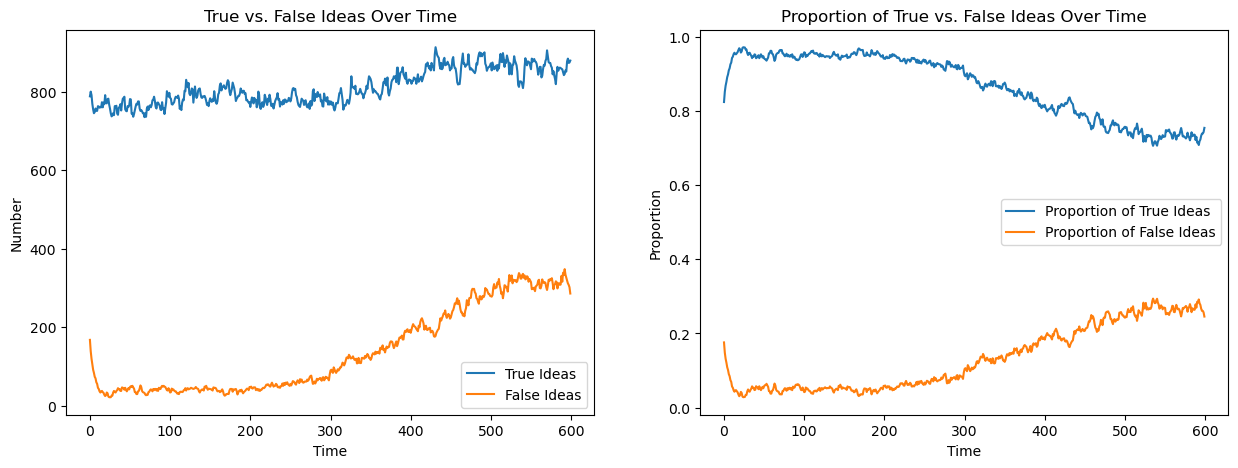

In [556]:
plot_data_proportions(model_data, 
                      "True Ideas", "False Ideas", 
                      "True vs. False Ideas Over Time", "Proportion of True vs. False Ideas Over Time",
                      False)

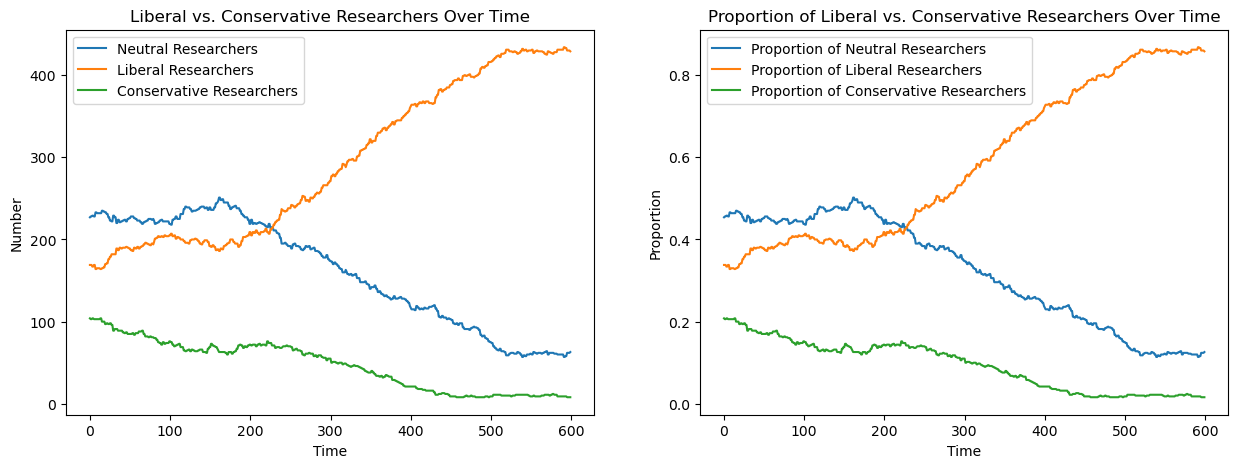

In [557]:
plot_data_proportions(model_data, 
                       "Liberal Researchers", 
                       "Conservative Researchers", 
                      "Liberal vs. Conservative Researchers Over Time", 
                      "Proportion of Liberal vs. Conservative Researchers Over Time",
                      "Neutral Researchers")

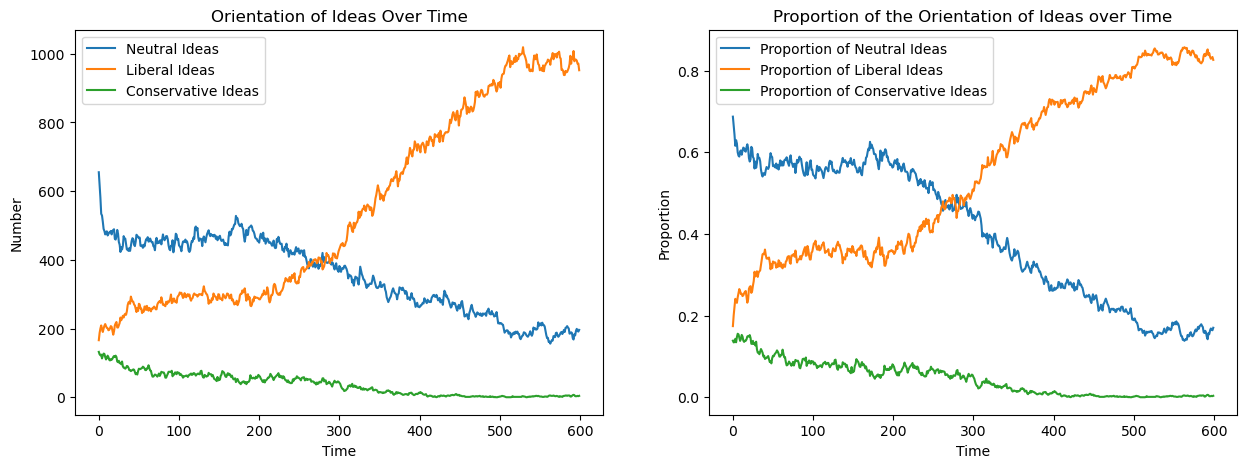

In [558]:
plot_data_proportions(model_data, 
                       "Liberal Ideas", 
                       "Conservative Ideas", 
                      "Orientation of Ideas Over Time", 
                      "Proportion of the Orientation of Ideas over Time",
                      "Neutral Ideas")





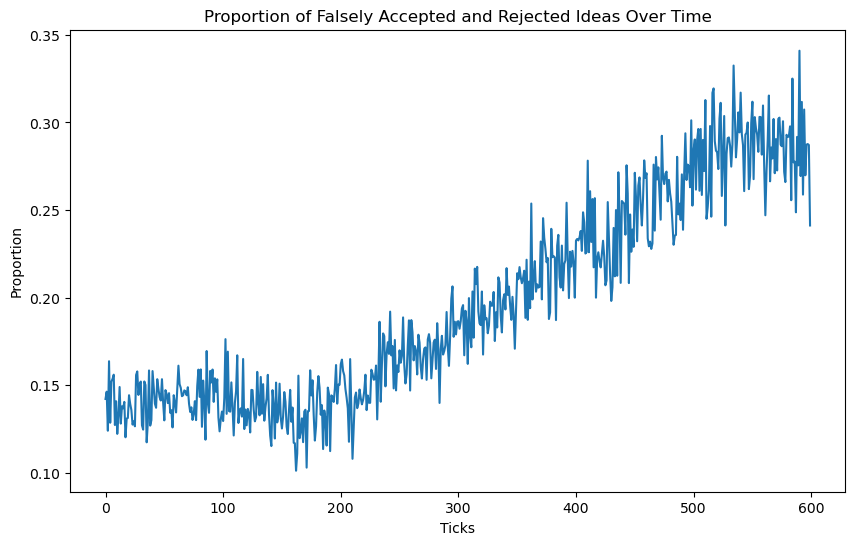

In [559]:
plt.figure(figsize=(10, 6))
plt.plot(model_data["Proportion Accepted"], label="Proportion of Accepted Ideas")

plt.xlabel("Ticks")
plt.ylabel("Proportion")
plt.title("Proportion of Falsely Accepted and Rejected Ideas Over Time")

plt.show()

# Batch run to compare variables

Run all cells in this section.

This can be used to run the model many times, each time varying some of the parameters such that you can see how results differ when certain parameters are changed together. Note: this can take very long if you want to run it for too many different values and variables. Either keep the values as I have put them here, or experiment and break the process (go to 'Kernel' and click 'interrupt kernel' if you see the time estimate is too long, and then try again with fewer n_vals, n_ticks, N and num_ideas).

Note: I'm now only varying:
- p_false_positives: the tendency of ideological bias to make false papers pass as true
- p_false_negatives: the tendence of ideological bias to make true papers fail
- p_ideology_true: the tendency of researchers to write papers in line with their non-neutral ideology
- cost_neutral: the rate at which academia is becoming more ideologically laden (i.e. more liberal and conservative, less neutral)

We can vary more parameters, but we have to choose this wisely as it can take a lot of time: with each additional varying parameter, the number of models to run gets multiplied again, so it shoots up very quickly.




In [560]:
# Step 1: Define parameters to vary

n_vals = 4

N = 500
num_ideas = 1000
n_ticks = 150# number of half years the model should run




variable_params = {'N' : N, 
                   'num_ideas' : num_ideas ,
                   'error' : 0.05 ,
                   'p_false_positive' : np.linspace(0.05, 0.95, n_vals) ,
                   'p_false_negative' : np.linspace(0.05, 0.95, n_vals) ,
                   'p_neutral_start' : 0.45 ,
                   'p_liberal_start' : 0.35 ,
                   'p_true_start' : 0.8, 
                   'p_neutral_ideas_start' : 0.7,
                   'p_liberal_ideas_start' : 0.2,
                   'p_new_idea' : 0.8,
                   'p_new_idea_true' : 0.5,
                   'p_ideology_idea' : np.linspace(0.05, 0.95, n_vals),
                   'prop_remove_ideas' : 0.2,
                   'prop_minim_neutral' : 0.15,
                   'cost_neutral' : np.linspace(1, 1.8, n_vals) }


# Step 2: Set up BatchRunnerMP
batch_run = mesa.batch_run(
    model_cls=ResearchModel,
    parameters=variable_params,
    data_collection_period = 1,
    # Number of iterations per combination of parameters
    max_steps=n_ticks, 
    number_processes = 1# Number of steps per model run
     # Collect data
)


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [29:50<00:00,  6.99s/it]


In [561]:

# with open('IB_5_3_N100_I500.pkl', 'wb') as file:
#     pickle.dump(batch_run, file)


In [562]:

results_df = pd.DataFrame(batch_run)

# Define sliders for each parameter based on their ranges in variable_params
@interact(
    p_false_positive=SelectionSlider(options = variable_params['p_false_positive'], value=0.05, description='p_false_positive', layout=slider_layout, style= {'description_width': 'initial'}),
    p_false_negative=SelectionSlider(options = variable_params['p_false_negative'], value=0.05, description='p_false_negative', layout=slider_layout, style= {'description_width': 'initial'}),
    p_ideology_idea=SelectionSlider(options = variable_params['p_ideology_idea'], value=0.05, description='p_ideology_idea', layout=slider_layout, style= {'description_width': 'initial'}),
    cost_neutral=SelectionSlider(options = variable_params['cost_neutral'], value=1, description='cost_neutral', layout=slider_layout, style= {'description_width': 'initial'})  # Adjust the range as needed
)
def interactive_plot(p_false_positive, p_false_negative, p_ideology_idea, cost_neutral):
    plot_results(results_df, p_false_positive, p_false_negative, p_ideology_idea, cost_neutral)

interactive(children=(SelectionSlider(description='p_false_positive', layout=Layout(width='300px'), options=(0…